In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import statsmodels.api as sm
from src import utils_plot as utils

wwtp list

In [2]:
wwtp_list_path = "../OSM_HW_EPA_All Tagged and Sourced.xlsx"
wwtp_list = pd.read_excel(wwtp_list_path, header=1, index_col=0)
wwtp_list = wwtp_list[
    [
        "filename",
        "State",
        "WWTP",
        "Solar",
        "Data Source",
        "Latitude",
        "Longitude",
        "LAT_OUT",
        "LON_OUT",
        "lat",
        "lon",
    ]
]
wwtp_list.loc[wwtp_list["Data Source"] == "HydroWASTE", "Lat"] = wwtp_list.loc[
    wwtp_list["Data Source"] == "HydroWASTE", "LAT_OUT"
]
wwtp_list.loc[wwtp_list["Data Source"] == "HydroWASTE", "Lon"] = wwtp_list.loc[
    wwtp_list["Data Source"] == "HydroWASTE", "LON_OUT"
]
wwtp_list.loc[wwtp_list["Data Source"] == "OpenStreetMap", "Lat"] = wwtp_list.loc[
    wwtp_list["Data Source"] == "OpenStreetMap", "Latitude"
]
wwtp_list.loc[wwtp_list["Data Source"] == "OpenStreetMap", "Lon"] = wwtp_list.loc[
    wwtp_list["Data Source"] == "OpenStreetMap", "Longitude"
]
wwtp_list.loc[wwtp_list["Data Source"] == "EPA", "Lat"] = wwtp_list.loc[
    wwtp_list["Data Source"] == "EPA", "lat"
]
wwtp_list.loc[wwtp_list["Data Source"] == "EPA", "Lon"] = wwtp_list.loc[
    wwtp_list["Data Source"] == "EPA", "lon"
]
wwtp_list.drop(
    columns=["LAT_OUT", "LON_OUT", "lat", "lon", "Latitude", "Longitude"], inplace=True
)
wwtp_list["Lat"] = wwtp_list["Lat"].astype(float)
wwtp_list["Lon"] = wwtp_list["Lon"].astype(float)
wwtp_list = gpd.GeoDataFrame(
    wwtp_list,
    geometry=gpd.points_from_xy(wwtp_list.Lon, wwtp_list.Lat),
    crs="EPSG:4326",
)
wwtp_list.head()

,filename,State,WWTP,Solar,Data Source,Lat,Lon,geometry
0,Alan Horton WWTF,CALIFORNIA,Yes,Yes,HydroWASTE,33.848,-116.469,POINT (-116.46900 33.84800)
1,Alberhill WWTP,CALIFORNIA,Yes,No,HydroWASTE,33.740,-117.423,POINT (-117.42300 33.74000)
2,Alturas WWTP,CALIFORNIA,Yes,No,HydroWASTE,41.469,-120.569,POINT (-120.56900 41.46900)
3,Anderson WWTF,CALIFORNIA,Yes,No,HydroWASTE,40.473,-122.260,POINT (-122.26000 40.47300)
4,Arcata WWTF,CALIFORNIA,Yes,No,HydroWASTE,40.848,-124.085,POINT (-124.08500 40.84800)


In [3]:
solar_list = wwtp_list[wwtp_list["Solar"] == "Yes"]
print(solar_list.shape)
solar_list.head()

(191, 8)


,filename,State,WWTP,Solar,Data Source,Lat,Lon,geometry
0,Alan Horton WWTF,CALIFORNIA,Yes,Yes,HydroWASTE,33.848,-116.469,POINT (-116.46900 33.84800)
7,Bakersfield WWTP 3,CALIFORNIA,Yes,Yes,HydroWASTE,35.181,-119.098,POINT (-119.09800 35.18100)
8,BANNING WWTF,CALIFORNIA,Yes,Yes,HydroWASTE,33.898,-116.794,POINT (-116.79400 33.89800)
11,BIG BEAR AREA REG WWTF,CALIFORNIA,Yes,Yes,HydroWASTE,34.277,-116.806,POINT (-116.80600 34.27700)
22,Chico WPCP,CALIFORNIA,Yes,Yes,HydroWASTE,39.606,-121.948,POINT (-121.94800 39.60600)


## WWTP distribution with 1km x 1km gridded population

Data source: https://hub.worldpop.org/project/categories?id=3

In [4]:
pop_tif_path = "../00_source_data//us/usa_ppp_2020_1km_Aggregated.tif"
pop_tif = rasterio.open(pop_tif_path)
print(pop_tif.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -99999.0, 'width': 43072, 'height': 6298, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0083333333, 0.0, -179.15124930330558,
       0.0, -0.0083333333, 71.39124988994655)}


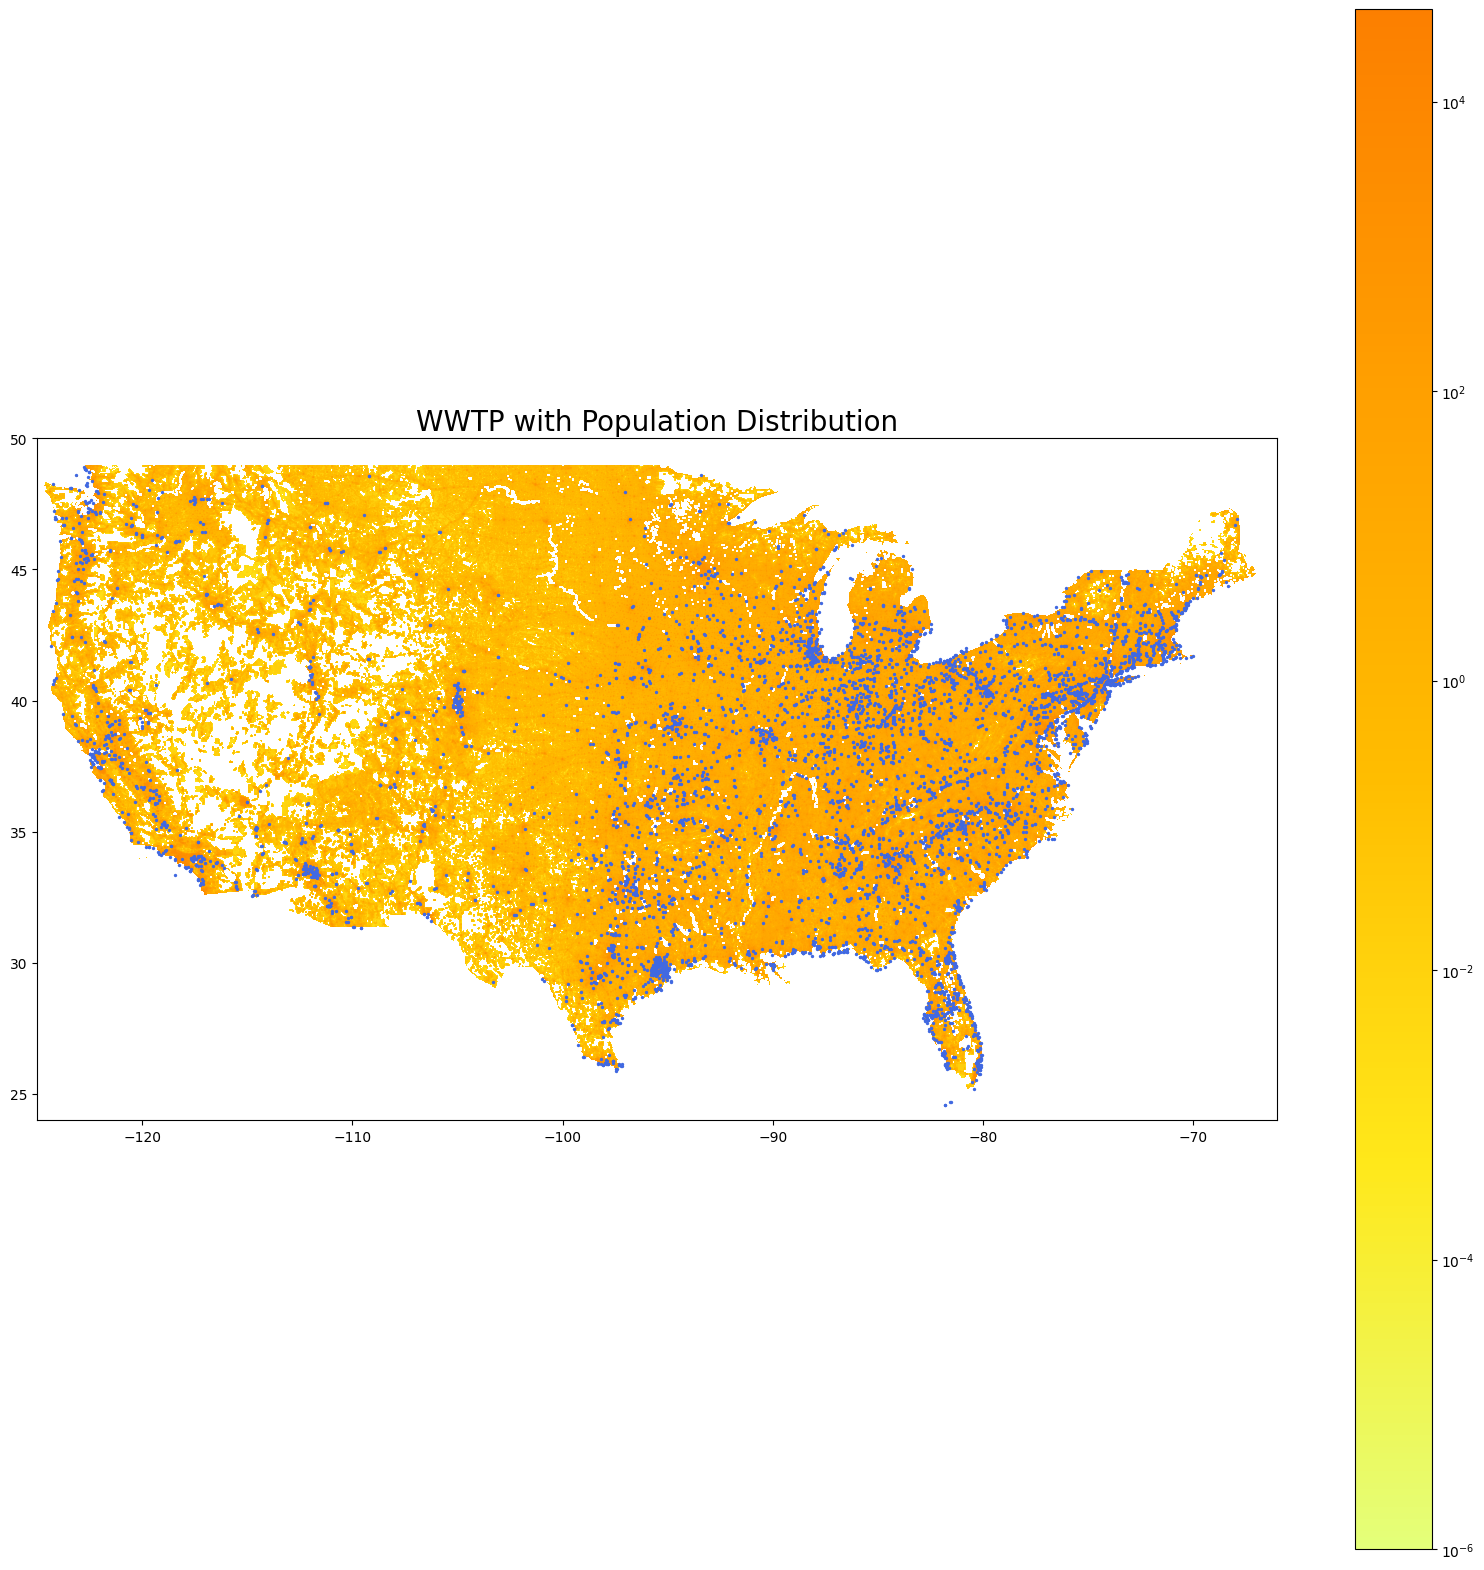

In [5]:
utils.wwtp_with_pop_distribution(
    wwtp=wwtp_list,
    gridded_pop=pop_tif,
    color="royalblue",
    colormap="Wistia",
    title="WWTP with Population Distribution",
)

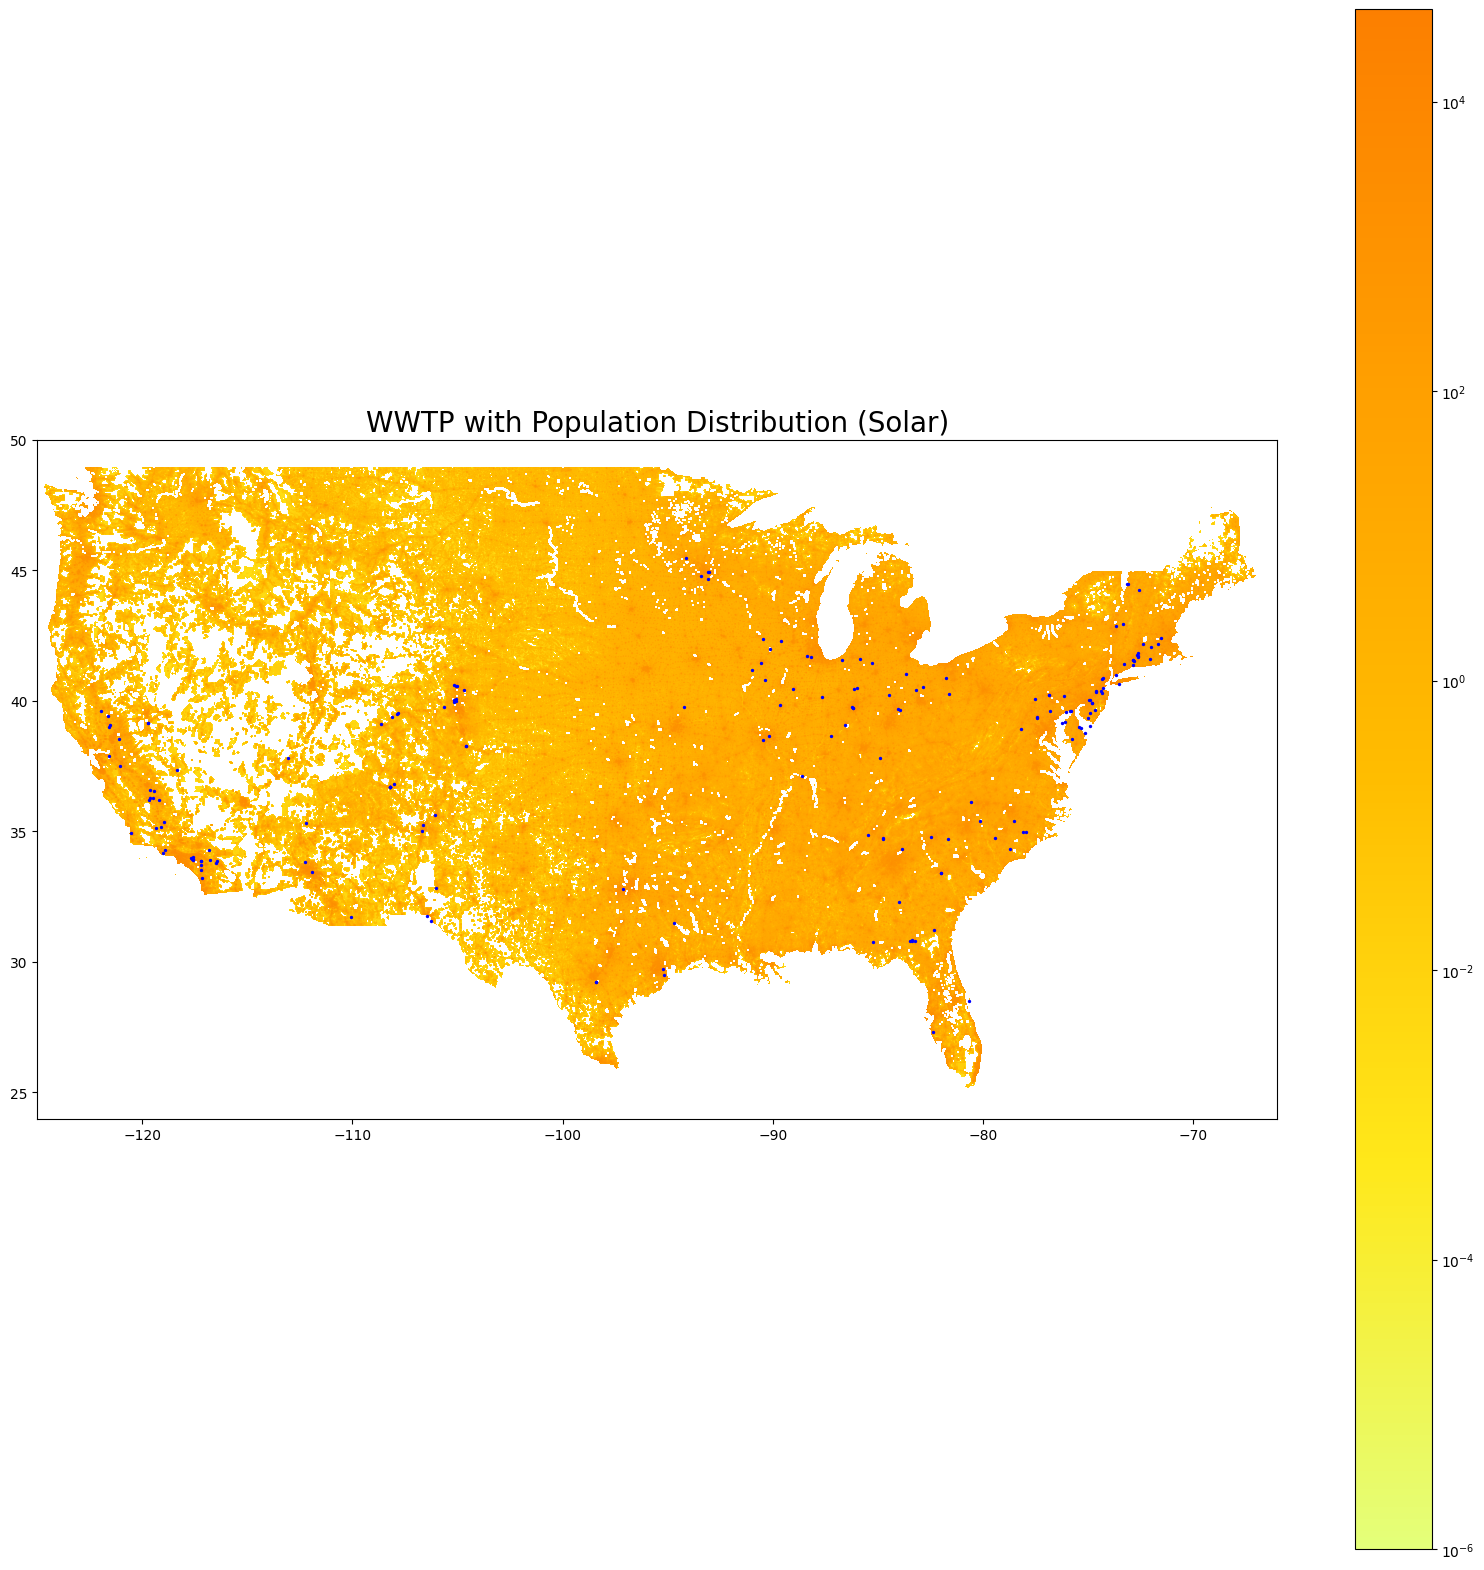

In [6]:
utils.wwtp_with_pop_distribution(
    wwtp=solar_list,
    gridded_pop=pop_tif,
    color="blue",
    colormap="Wistia",
    title="WWTP with Population Distribution (Solar)",
)

## Correlation of WWTP counts with population / income by state

Data source:

https://data.census.gov/table/ACSDP1Y2022.DP05?t=Populations%20and%20People&g=010XX00US$0400000&y=2022&moe=false

https://data.census.gov/table/ACSST1Y2022.S1901?t=Income%20(Households,%20Families,%20Individuals)&g=010XX00US$0400000&y=2022&moe=false

In [7]:
statewise_pop_path = "../00_source_data/us/ACSDP1Y2022.DP05-2024-04-18T162538.csv"
statewise_pop = utils.process_state_data(
    path=statewise_pop_path, column_name="population"
)
statewise_pop.head()

,state,population
0,ALABAMA,5074296
1,ALASKA,733583
2,ARIZONA,7359197
3,ARKANSAS,3045637
4,CALIFORNIA,39029342


In [8]:
statewise_income_path = "../00_source_data/us/ACSST1Y2022.S1901-2024-04-20T204932.csv"
statewise_income = utils.process_state_data(
    path=statewise_income_path, column_name="income"
)
statewise_income.head()

,state,income
0,ALABAMA,2016448
1,ALASKA,274574
2,ARIZONA,2850377
3,ARKANSAS,1216207
4,CALIFORNIA,13550586


In [9]:
wwtp_list_cnt_by_state = wwtp_list.groupby("State").size()
# merge the two dataframes
wwtp_list_cnt_by_state = wwtp_list_cnt_by_state.reset_index()
wwtp_list_cnt_by_state.columns = ["state", "wwtp_count"]
solar_list_cnt_by_state = solar_list.groupby("State").size()
solar_list_cnt_by_state = solar_list_cnt_by_state.reset_index()
solar_list_cnt_by_state.columns = ["state", "solar_wwtp_count"]

merged_df = statewise_pop.merge(statewise_income, on="state")
merged_df = merged_df.merge(wwtp_list_cnt_by_state, on="state")
merged_df = merged_df.merge(solar_list_cnt_by_state, on="state", how="outer")
merged_df.fillna(0, inplace=True)
merged_df.head()

,state,population,income,wwtp_count,solar_wwtp_count
0,ALABAMA,5074296,2016448,206,0.0
1,ARIZONA,7359197,2850377,232,3.0
2,ARKANSAS,3045637,1216207,81,0.0
3,CALIFORNIA,39029342,13550586,272,35.0
4,COLORADO,5839926,2384584,132,14.0


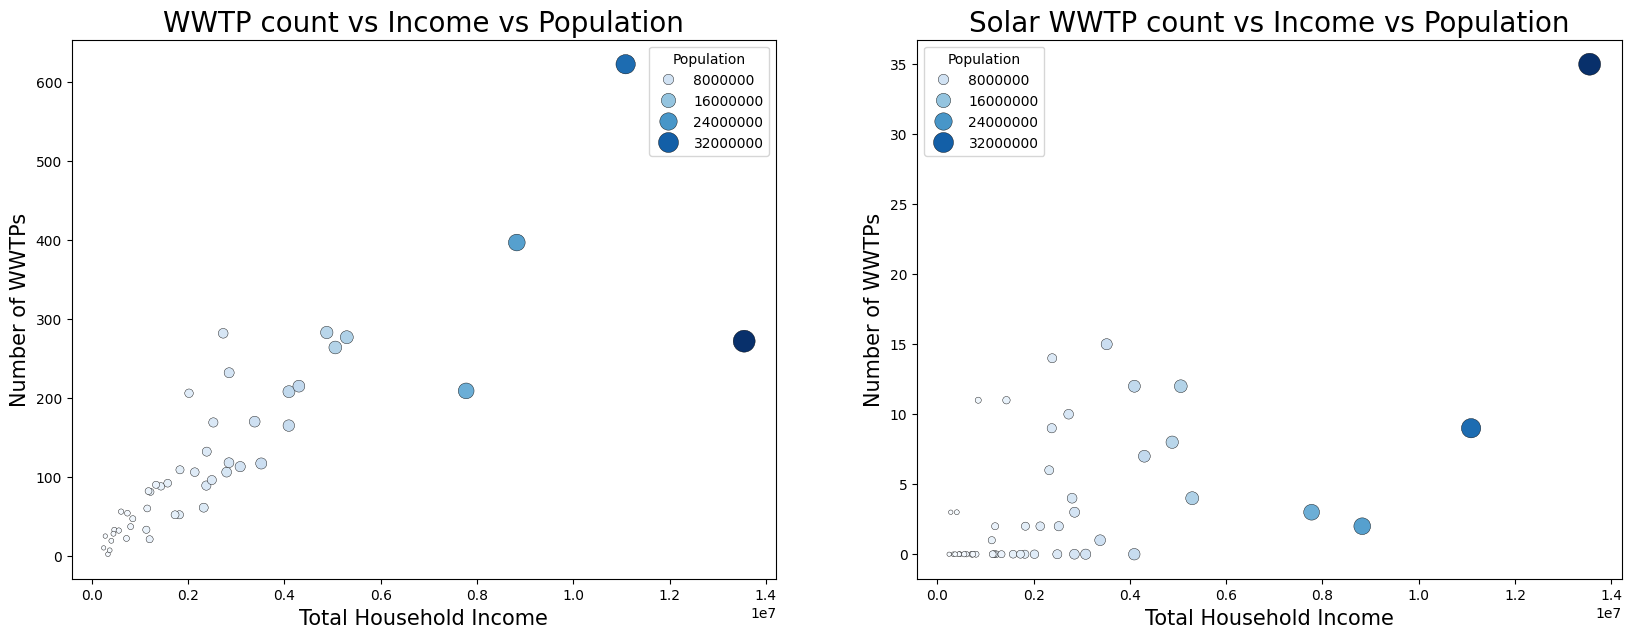

In [10]:
# 2 subplots with ax1 and ax2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
utils.plt_pop_income_wwtp(
    merged_df,
    title="WWTP count vs Income vs Population",
    ax=ax1,
    column_name="wwtp_count",
)
utils.plt_pop_income_wwtp(
    merged_df,
    title="Solar WWTP count vs Income vs Population",
    ax=ax2,
    column_name="solar_wwtp_count",
)
plt.show()

## Fit a Regression Line



WWTP count with Population

                            OLS Regression Results                            
Dep. Variable:             wwtp_count   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     91.15
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           1.74e-12
Time:                        18:07:46   Log-Likelihood:                -270.39
No. Observations:                  48   AIC:                             544.8
Df Residuals:                      46   BIC:                             548.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.7588     13.588      2.779      0.0

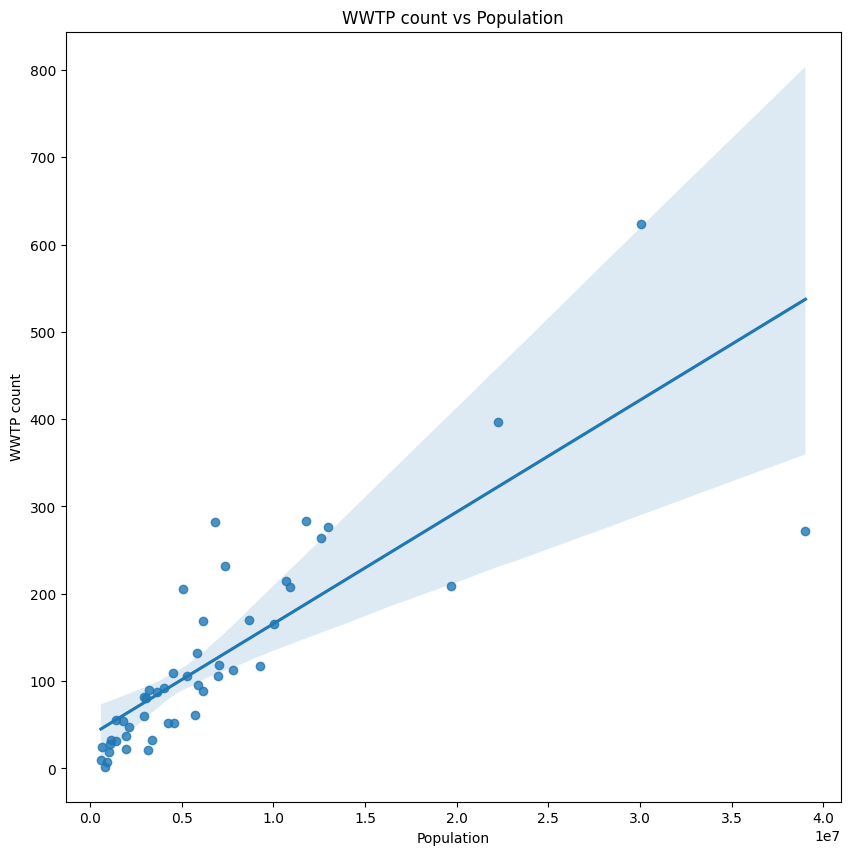

In [11]:
utils.lr_analysis(
    merged_df,
    x_col="population",
    y_col="wwtp_count",
    x_label="Population",
    y_label="WWTP count",
    titte="WWTP count vs Population",
)

WWTP count with Total Household Income

                            OLS Regression Results                            
Dep. Variable:             wwtp_count   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     108.9
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           1.03e-13
Time:                        18:07:46   Log-Likelihood:                -267.46
No. Observations:                  48   AIC:                             538.9
Df Residuals:                      46   BIC:                             542.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7273     13.150      2.261      0.0

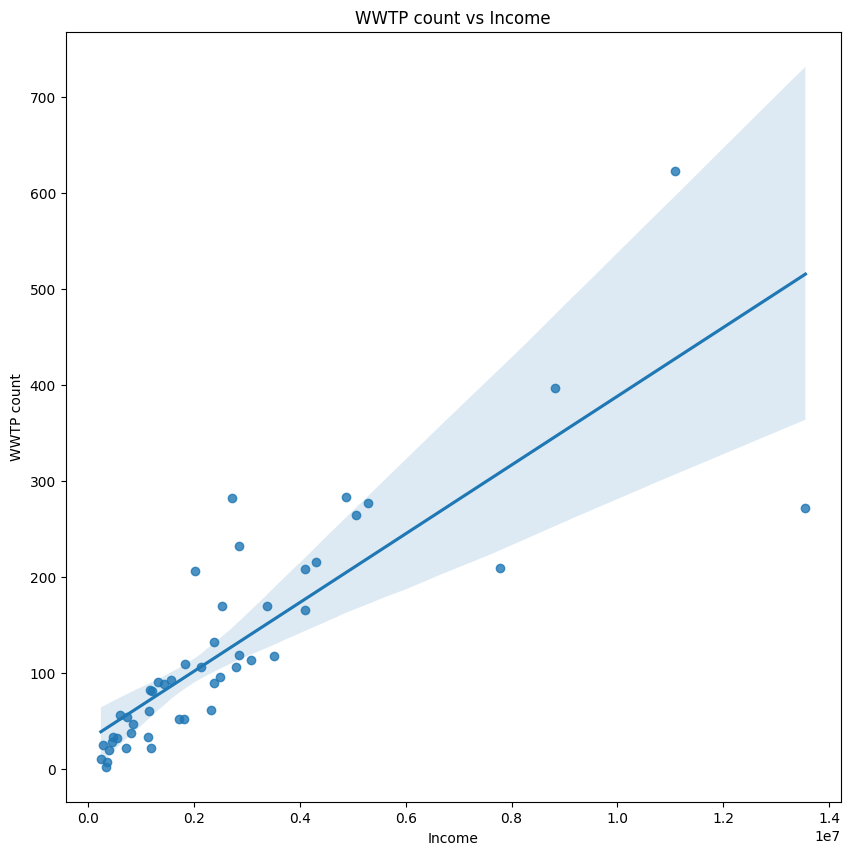

In [12]:
utils.lr_analysis(
    merged_df,
    x_col="income",
    y_col="wwtp_count",
    x_label="Income",
    y_label="WWTP count",
    titte="WWTP count vs Income",
)

WWTP count (with solar) with Population

                            OLS Regression Results                            
Dep. Variable:       solar_wwtp_count   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     34.33
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           4.70e-07
Time:                        18:07:46   Log-Likelihood:                -143.22
No. Observations:                  48   AIC:                             290.4
Df Residuals:                      46   BIC:                             294.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1554      0.961      0.162      0.8

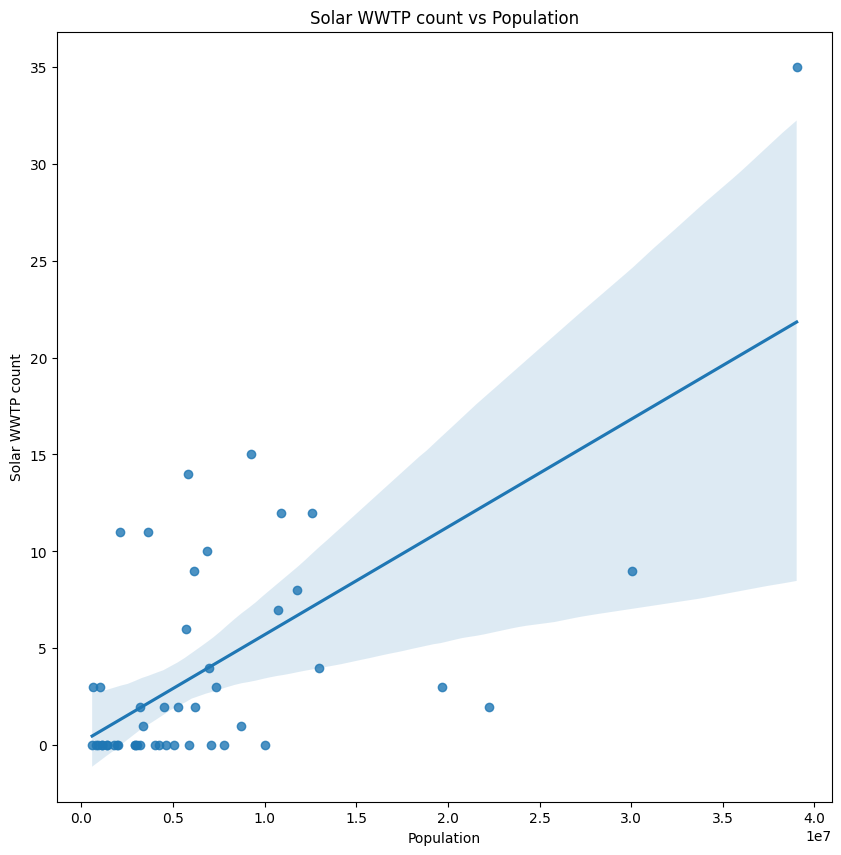

In [13]:
utils.lr_analysis(
    merged_df,
    x_col="population",
    y_col="solar_wwtp_count",
    x_label="Population",
    y_label="Solar WWTP count",
    titte="Solar WWTP count vs Population",
)

WWTP count (with solar) with Income

                            OLS Regression Results                            
Dep. Variable:       solar_wwtp_count   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     29.52
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           2.03e-06
Time:                        18:07:46   Log-Likelihood:                -144.71
No. Observations:                  48   AIC:                             293.4
Df Residuals:                      46   BIC:                             297.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0996      1.019      0.098      0.9

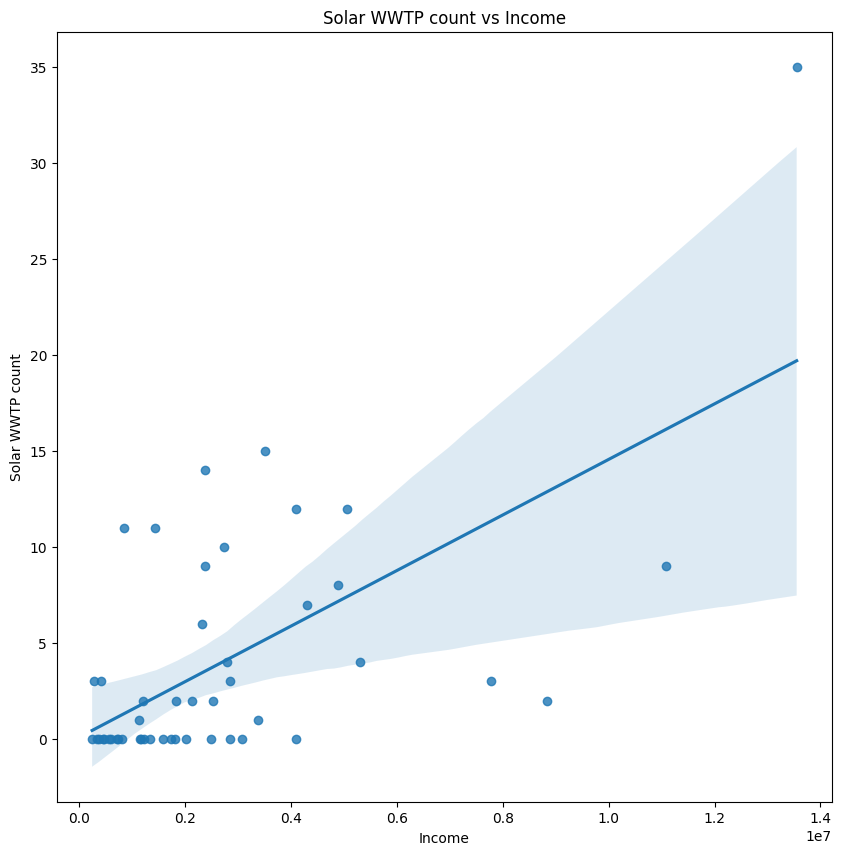

In [14]:
utils.lr_analysis(
    merged_df,
    x_col="income",
    y_col="solar_wwtp_count",
    x_label="Income",
    y_label="Solar WWTP count",
    titte="Solar WWTP count vs Income",
)

### Try WWTP count with Population + Income

In [15]:
utils.lr_analysis(
    merged_df,
    x_col=["population", "income"],
    y_col="wwtp_count",
    x_label="Population and Income",
    y_label="WWTP count",
    titte="WWTP count vs Population and Income",
    if_plt=False,
)

                            OLS Regression Results                            
Dep. Variable:             wwtp_count   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     77.75
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           2.51e-15
Time:                        18:07:47   Log-Likelihood:                -260.74
No. Observations:                  48   AIC:                             527.5
Df Residuals:                      45   BIC:                             533.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9386     12.894      0.616      0.5

In [16]:
utils.lr_analysis(
    merged_df,
    x_col=["population", "income"],
    y_col="solar_wwtp_count",
    x_label="Population and Income",
    y_label="Solar WWTP count",
    titte="Solar WWTP count vs Population and Income",
    if_plt=False,
)

                            OLS Regression Results                            
Dep. Variable:       solar_wwtp_count   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     27.08
Date:                Sat, 20 Apr 2024   Prob (F-statistic):           1.90e-08
Time:                        18:07:47   Log-Likelihood:                -137.64
No. Observations:                  48   AIC:                             281.3
Df Residuals:                      45   BIC:                             286.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8253      0.992      1.840      0.0